In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn

from tqdm import tqdm
from random import shuffle
from sklearn.metrics import f1_score

from dataloader import load_data, CustomDataset
from model import init_model, train

In [2]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [3]:
# set device to GPU
dev = "cuda:0"

In [4]:
channel_names = [
    "DeforLag4",
    "DeforLag3",
    "DeforLag2",
    "DeforLag1",
    "Population",
    "PopDensity",
    "MunDeforLag4",
    "MunDeforLag3",
    "MunDeforLag2",
    "MunDeforLag1",
    "PrecipLag4",
    "PrecipLag3",
    "PrecipLag2",
    "PrecipLag1",
    "TPIAvg",
    "TPIMin",
    "TPIMax",
    "TPIStd",
    "Land1",
    "Land2",
    "Land3",
    "PastDefor",
    "NightLightsAvg",
    "NightLightsMax",
    "Sentinel"
]
len(channel_names)

25

In [5]:
# load all data
(
    train_data, val_data, test_data,
    patches, frames_idx, 
    county_data,
    counties_time_grid,
    precip_time_grid,
    tpi_array,
    landcover_array,
    scores_time_grid,
    night_time_grid,
    sentinel_time_grid
) = load_data()

Creating counties defor time grid: 28it [00:03,  7.02it/s]
Creating precipitations time grid: 28it [00:03,  8.06it/s]
Creating scores time grid: 28it [00:00, 32.53it/s]
Creating night lights time grid: 28it [00:06,  4.24it/s]
Creating sentinel time grid: 28it [00:03,  9.03it/s]
Computing patches: 100%|██████████| 32/32 [00:20<00:00,  1.59it/s]


In [6]:
# channels to be used
channels = [0, 1, 2, 3, 5, 20, 23, 24]

In [7]:
trainloader = torch.utils.data.DataLoader(
    CustomDataset(
        np.concatenate([train_data, val_data]), 
        patches, 
        frames_idx, 
        county_data,
        counties_time_grid,
        precip_time_grid,
        tpi_array,
        landcover_array,
        scores_time_grid,
        night_time_grid,
        sentinel_time_grid,
        channels
    ),
    batch_size=64,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    CustomDataset(
        test_data, 
        patches, 
        frames_idx, 
        county_data,
        counties_time_grid,
        precip_time_grid,
        tpi_array,
        landcover_array,
        scores_time_grid,
        night_time_grid,
        sentinel_time_grid,
        channels
    ),
    batch_size=1,
    shuffle=True
)

In [8]:
# # train model
# n_epochs = 15
# model, optimizer = init_model(len(channels))
# train(model, optimizer, n_epochs, trainloader, testloader)

In [9]:
# load weights from trained model
model, optimizer = init_model(len(channels))
model.load_state_dict(torch.load("DeepLabV3+_final.pt"))

<All keys matched successfully>

# Learning curves

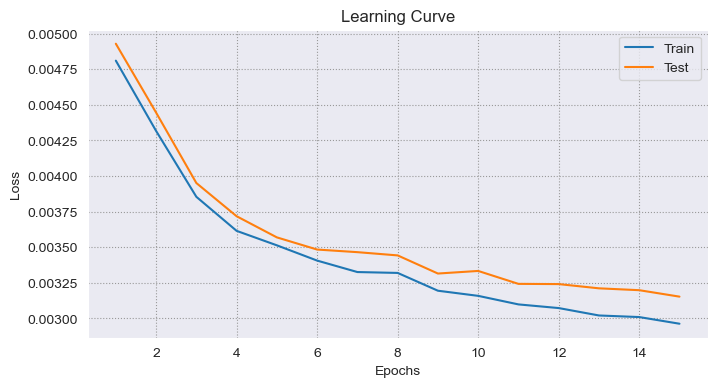

In [21]:
fig, ax = plt.subplots(figsize=(8, 4))
x = np.array(range(len(model.errs))) + 1
sns.lineplot(x=x, y=[float(e[0]) for e in model.errs], label="Train")
sns.lineplot(x=x, y=[float(e[1]) for e in model.errs], label="Test")
ax.set_title("Learning Curve")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
plt.show()

# Confusion Matrix

In [11]:
# softmax function will be needed
softmax_ = nn.Softmax(dim=1)

## Train

In [12]:
# get prediction values as binary
y_true = []
y_pred = []
for inputs, labels in trainloader:
    y_hat = model(inputs).detach()
    y_true.append(labels[:, 1, :, :].cpu())
    y_pred.append(softmax_(y_hat)[:, 1, :, :].cpu())

In [13]:
# flatten
y_true = np.concatenate(y_true).flatten() 
y_pred = np.concatenate(y_pred).flatten()

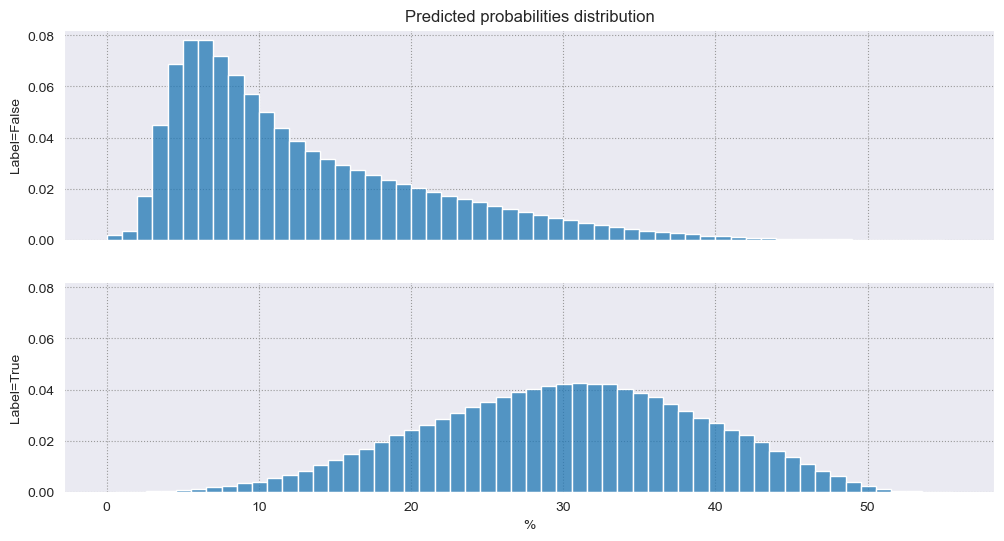

In [14]:
fig, ax = plt.subplots(2, figsize=(12, 6), sharex=True, sharey=True)
sns.histplot(100*y_pred[np.where(y_true==0)], binwidth=1, ax=ax[0], stat="probability")
sns.histplot(100*y_pred[np.where(y_true==1)], binwidth=1, ax=ax[1], stat="probability")
ax[0].set_title("Predicted probabilities distribution")
ax[1].set_xlabel("%")
ax[0].set_ylabel("Label=False")
ax[1].set_ylabel("Label=True")
plt.show()

In [26]:
# select probability treshold
scores = []
for p_treshold in tqdm(range(27, 37)):
    scores.append(
        f1_score(
            y_true, 
            y_pred > p_treshold / 100
        )
    )

100%|██████████| 10/10 [01:26<00:00,  8.70s/it]


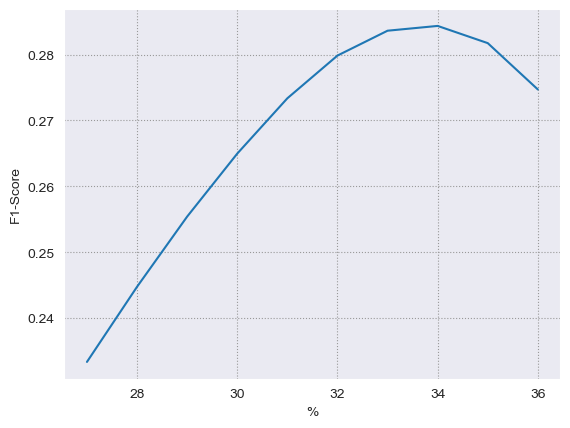

In [27]:
g = sns.lineplot(x=range(27, 37), y=scores)
g.set_xlabel("%")
g.set_ylabel("F1-Score")
plt.show()

In [15]:
# apply confusion matrix with probability treshold
p_treshold = 0.34

from sklearn.metrics import confusion_matrix
confusion_matrix(
    y_true, 
    y_pred > p_treshold,
    normalize="true"
)

array([[0.97786423, 0.02213577],
       [0.65277683, 0.34722317]])

In [30]:
confusion_matrix(
    y_true, 
    y_pred > p_treshold,
    normalize="pred"
)

array([[0.98635044, 0.76520589],
       [0.01364956, 0.23479411]])

## Validation

In [31]:
# get prediction values as binary
y_true = []
y_pred = []
for inputs, labels in testloader:
    y_hat = model(inputs).detach()
    y_true.append(labels[:, 1, :, :].cpu())
    y_pred.append(softmax_(y_hat)[:, 1, :, :].cpu())

In [32]:
# flatten
y_true = np.concatenate(y_true).flatten() 
y_pred = np.concatenate(y_pred).flatten()

In [33]:
f1_score(
    y_true, 
    y_pred > p_treshold
)

0.2705224442389177

In [34]:
confusion_matrix(
    y_true, 
    y_pred > p_treshold,
    normalize="true"
)

array([[0.96454978, 0.03545022],
       [0.60017675, 0.39982325]])

In [45]:
confusion_matrix(
    y_true, 
    y_pred > p_treshold,
    normalize="pred"
)

array([[0.98252563, 0.80967681],
       [0.01747437, 0.19032319]])

# Prediction example

In [54]:
def get_sample(min_area=0.1, dataloader=trainloader):
    for input_, truth in dataloader:
        batches = list(range(truth.shape[0])) 
        shuffle(batches)
        for idx_batch in batches:
            if truth[idx_batch, 1, :, :].mean() > min_area:
                return input_, truth, idx_batch

In [67]:
input_, truth, idx_batch = get_sample(0.05, testloader)

pred = model(input_)

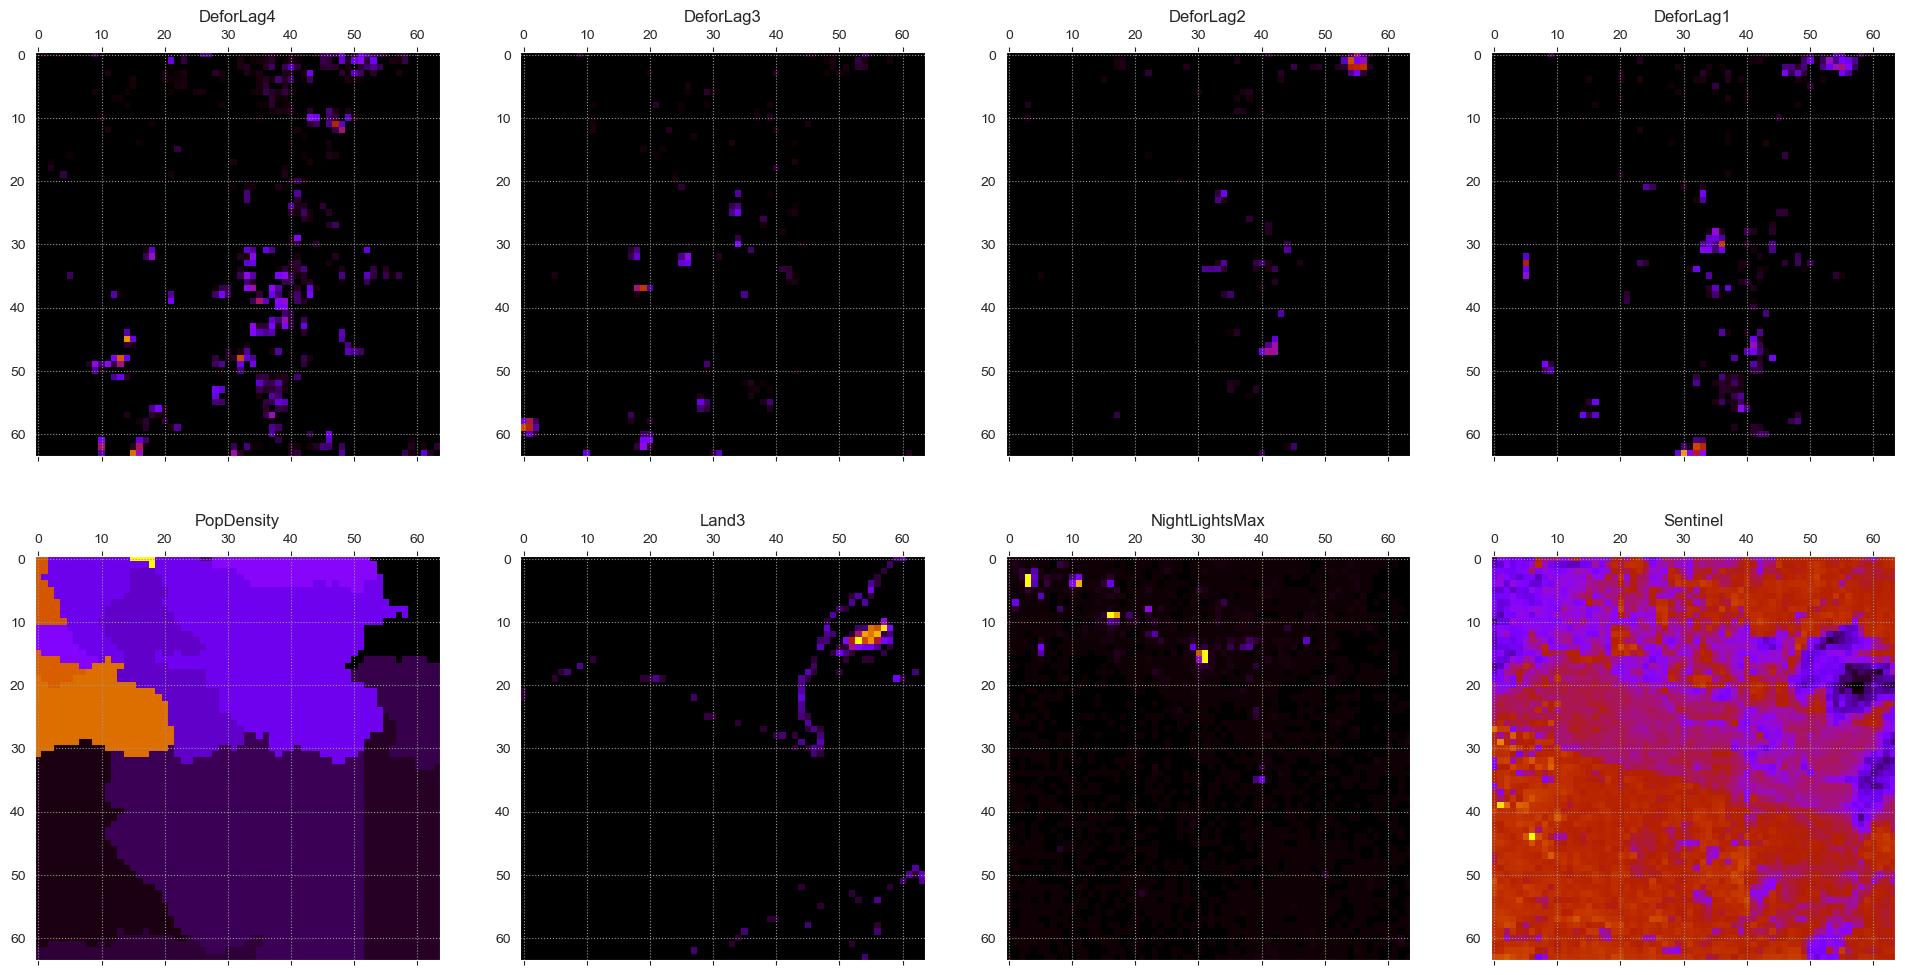

In [68]:
fig, ax = plt.subplots(2, 4, figsize=(24, 12))
for i in range(4):
    ax[0, i].matshow(input_[idx_batch, i, :, :].cpu(), cmap="gnuplot", vmin=truth.min(), vmax=truth.max())
    ax[0, i].set_title(channel_names[channels[i]])
for i in range(4):
    ax[1, i].matshow(input_[idx_batch, 4+i, :, :].cpu(), cmap="gnuplot")
    ax[1, i].set_title(channel_names[channels[i+4]])
plt.show()

C:\Users\giovanni\AppData\Local\Temp\ipykernel_10852\3550459363.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


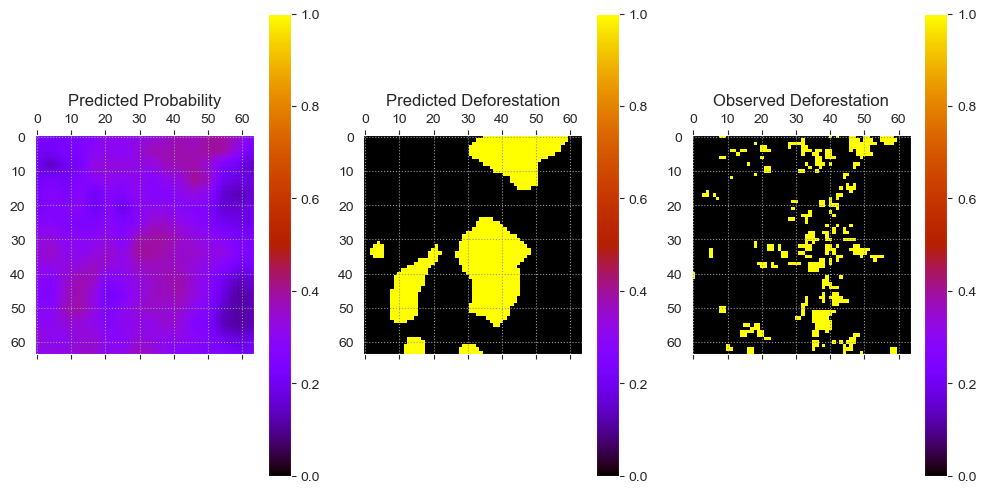

In [69]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
m1 = ax[2].matshow(truth[idx_batch, 1, :, :].cpu(), cmap="gnuplot", vmin=0, vmax=1)
m2 = ax[0].matshow(softmax_(pred).detach().cpu().numpy()[idx_batch, 1, :, :], cmap="gnuplot", vmin=0, vmax=1)
m3 = ax[1].matshow(softmax_(pred).detach().cpu().numpy()[idx_batch, 1, :, :] > p_treshold, cmap="gnuplot", vmin=0, vmax=1)
# ax[0].axis('off')
# ax[1].axis('off')
# ax[2].axis('off')
fig.colorbar(m1)
fig.colorbar(m2)
fig.colorbar(m3)
ax[0].set_title("Predicted Probability")
ax[1].set_title("Predicted Deforestation")
ax[2].set_title("Observed Deforestation")
fig.show()

# Score Map

In [189]:
loader = torch.utils.data.DataLoader(
    CustomDataset(
        test_data, 
        patches, 
        frames_idx, 
        county_data,
        counties_time_grid,
        precip_time_grid,
        tpi_array,
        landcover_array,
        scores_time_grid,
        night_time_grid,
        sentinel_time_grid,
        channels
    ),
    batch_size=1,
    shuffle=False
)

In [190]:
# get prediction values as binary
r = []
for index, (inputs, labels) in enumerate(loader):
    ipatch = index // (loader.dataset.X.shape[0] - loader.dataset.autor_window)
    y_hat = model(inputs).detach()
    y_true = labels[:, 1, :, :].cpu().flatten()
    y_pred = softmax_(y_hat)[:, 1, :, :].cpu().flatten()

    score_ = f1_score(
        y_true, 
        y_pred > p_treshold / 100
    )
    r.append((ipatch, score_))

In [155]:
# area_by_frame = pd.DataFrame(r, columns=["area_pred", "frame_id"])
# area_by_frame.head(2)

,area_pred,frame_id
0,0.117202,288
1,0.106385,289


In [191]:
score_by_patch = pd.DataFrame(r, columns=["patch_id", "score"]).groupby("patch_id").mean().reset_index()
score_by_patch.head(2)

,patch_id,score
0,0,0.030069
1,1,0.042736


In [192]:
# frame_by_patch
frame_by_patch = []
for (patch, frame_list) in enumerate(patches):
    for frame in frame_list:
        frame_by_patch.append((patch, frame))

frame_by_patch = pd.DataFrame(frame_by_patch, columns=["patch_id", "frame_id"])
frame_by_patch.head(2)

,patch_id,frame_id
0,0,288
1,0,289


In [193]:
score_by_frame = pd.merge(
    score_by_patch,
    frame_by_patch,
    on="patch_id",
    how="left",
    validate="1:m"
)
score_by_frame.head(2)

,patch_id,score,frame_id
0,0,0.030069,288
1,0,0.030069,289


In [172]:
import config
import geopandas as gpd
from utils import compute_frames
am_bounds = gpd.read_file(config.AMAZON_FRONTIER_DATA)
region = compute_frames(am_bounds.total_bounds, config.BOX_SIDE, 0, 1001, 0, 777)

In [194]:
region_with_scores = region.merge(score_by_frame, on="frame_id", how="left", validate="1:m").dropna()
region_with_scores.head()

,x,y,frame_id,geometry,patch_id,score
288,0,288,288,"POLYGON ((-73.96097 -9.40177, -73.96097 -9.371...",0.0,0.030069
289,0,289,289,"POLYGON ((-73.96097 -9.37177, -73.96097 -9.341...",0.0,0.030069
290,0,290,290,"POLYGON ((-73.96097 -9.34177, -73.96097 -9.311...",0.0,0.030069
291,0,291,291,"POLYGON ((-73.96097 -9.31177, -73.96097 -9.281...",0.0,0.030069
292,0,292,292,"POLYGON ((-73.96097 -9.28177, -73.96097 -9.251...",0.0,0.030069


In [195]:
patch_region_with_scores = region_with_scores.dissolve(by='patch_id', aggfunc='mean')
patch_region_with_scores.head(2)

,geometry,x,y,frame_id,score
patch_id,,,,,
0.0,"POLYGON ((-73.99097 -9.25177, -73.99097 -9.221...",31.5,319.5,24826.5,0.030069
1.0,"POLYGON ((-73.99097 -8.29177, -73.99097 -8.261...",31.5,351.5,24858.5,0.042736


<Axes: >

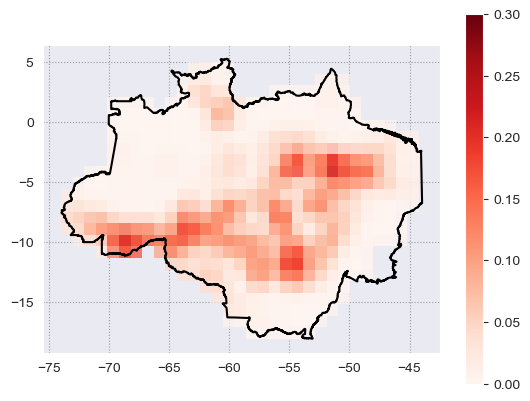

In [279]:
fig, ax = plt.subplots()
am_bounds.boundary.plot(ax=ax, color="black")
patch_region_with_scores.plot(column="score", ax=ax, cmap="Reds", legend=True, alpha=.7, linewidth=0, vmax=0.3)

## Prediction Map

In [294]:
# get prediction values as binary
r = []
for index, (inputs, labels) in tqdm(enumerate(loader), total=len(loader)):
    ipatch = index // (loader.dataset.X.shape[0] - loader.dataset.autor_window)
    y_hat = model(inputs).detach()
    y_pred = softmax_(y_hat)[:, 1, :, :].cpu().flatten().numpy()
    y_true = labels[:, 1, :, :].cpu().flatten().numpy()

    r = r + list(zip(patches[ipatch], y_pred, y_true, [ipatch for _ in y_pred]))

  0%|          | 0/1724 [00:00<?, ?it/s]

100%|██████████| 1724/1724 [03:31<00:00,  8.14it/s]


In [295]:
area_by_frame = pd.DataFrame(r, columns=["frame_id", "area_pred", "area_true", "patch_id"]).groupby(["patch_id", "frame_id"]).mean().reset_index()
area_by_frame.head(2)

,patch_id,frame_id,area_pred,area_true
0,0,288,0.118630,0.0
1,0,289,0.107942,0.0


In [296]:
region_with_areas = region.merge(area_by_frame, on="frame_id", how="right", validate="1:m").dropna()
region_with_areas.head()

,x,y,frame_id,geometry,patch_id,area_pred,area_true
0,0,288,288,"POLYGON ((-73.96097 -9.40177, -73.96097 -9.371...",0,0.118630,0.0
1,0,289,289,"POLYGON ((-73.96097 -9.37177, -73.96097 -9.341...",0,0.107942,0.0
2,0,290,290,"POLYGON ((-73.96097 -9.34177, -73.96097 -9.311...",0,0.098110,0.0
3,0,291,291,"POLYGON ((-73.96097 -9.31177, -73.96097 -9.281...",0,0.089084,0.0
4,0,292,292,"POLYGON ((-73.96097 -9.28177, -73.96097 -9.251...",0,0.080815,0.0


In [297]:
patch_region_with_areas = region_with_areas.dissolve(by='patch_id', aggfunc='mean')
patch_region_with_areas.head(2)

,geometry,x,y,frame_id,area_pred,area_true
patch_id,,,,,,
0,"POLYGON ((-73.99097 -9.25177, -73.99097 -9.221...",31.5,319.5,24826.5,0.139834,0.015442
1,"POLYGON ((-73.99097 -8.29177, -73.99097 -8.261...",31.5,351.5,24858.5,0.147951,0.022156


<Axes: >

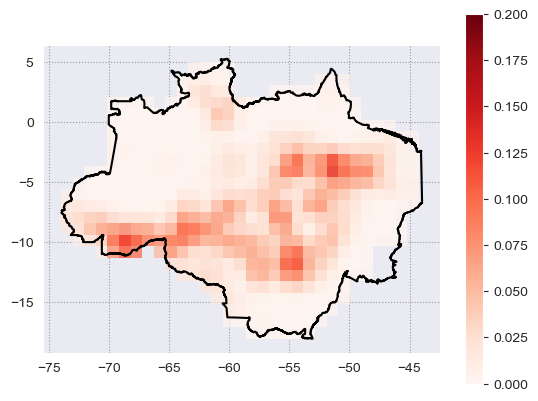

In [305]:
fig, ax = plt.subplots()
am_bounds.boundary.plot(ax=ax, color="black")
patch_region_with_areas.plot(column="area_true", ax=ax, cmap="Reds", legend=True, alpha=.7, linewidth=0, vmax=0.2)

<Axes: >

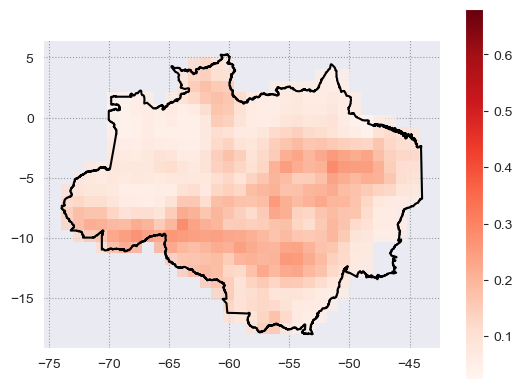

In [303]:
fig, ax = plt.subplots()
am_bounds.boundary.plot(ax=ax, color="black")
patch_region_with_areas.plot(column="area_pred", ax=ax, cmap="Reds", legend=True, alpha=.7, linewidth=0, vmax=2*p_treshold)

# Save model

In [70]:
torch.save(model.state_dict(), r"DeepLabV3+_final.pt")

# Output

In [42]:
def extract_log_info(filepath):
    """
    Read log file and extract added channels and scores
    """
    with open(filepath) as file:
        lines = file.readlines()
        lines = [
            l.strip().split(": ")[1:] for l in lines 
            if ("New channel added" in l)
        ]
        updates = []
        for l in lines:
            vals = l[1].split(" ")
            new_channel = vals[0]
            train1 = vals[1][2:-1]
            test1 = vals[2][:-1]
            train2 = vals[4][1:-1]
            test2 = vals[5][:-2]
            updates.append((
                int(new_channel), 
                float(train1), 
                float(test1), 
                float(train2), 
                float(test2)
            ))
        updates = pd.DataFrame(updates, columns=["new_channel","train_score_before", "test_score_before", "train_score_after", "test_score_after"])
        updates["gain_test"] = updates["test_score_after"] - updates["test_score_before"]
        updates["new_channel_name"] = [channel_names[i] for i in updates.new_channel]
        return updates

In [43]:
logs_df = []
for (irun, filename) in enumerate(os.listdir("logs")):
     if filename.startswith("FeatureSelection"):
          file_df = extract_log_info(os.path.join("logs", filename))
          file_df["run"] = irun
          logs_df.append(file_df)
logs_df = pd.concat(logs_df)

In [46]:
logs_df[["new_channel", "new_channel_name"]].value_counts()

new_channel  new_channel_name
5            PopDensity          10
20           Land3                3
23           NightLightsMax       3
24           Sentinel             3
10           PrecipLag4           2
16           TPIMax               2
21           PastDefor            2
7            MunDeforLag3         1
11           PrecipLag3           1
14           TPIAvg               1
18           Land1                1
19           Land2                1
Name: count, dtype: int64

<Axes: xlabel='new_channel_name', ylabel='gain_test'>

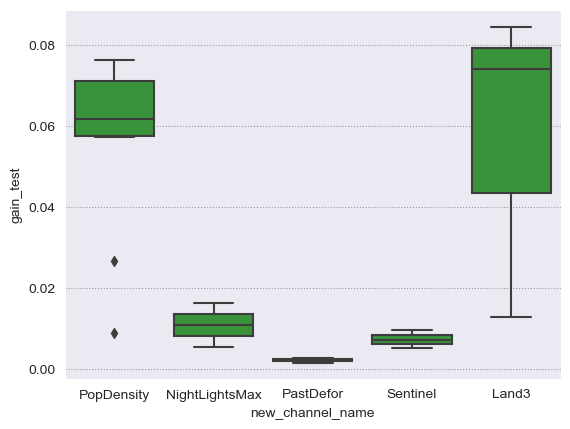

In [45]:
sns.boxplot(
    data=logs_df[
        logs_df["new_channel_name"].isin(logs_df["new_channel_name"].value_counts().index[:5])
    ], 
    x="new_channel_name", y="gain_test",
    color=sns.color_palette()[2]
)